In [1]:
# Data
from sample_data_fetcher import SampleDataFetcher

date = '2022-08-15'
fetcher = SampleDataFetcher()
atm_prices = fetcher.option_contracts(date, ticker = 'SPX')
option_raw_prices = fetcher.option_prices(date, ticker = 'SPX')
forward_prices = fetcher.forward_prices(date, ticker = 'SPX')
fetcher.close()

# The strike prices are * 1000 in the raw data
option_raw_prices.loc[:, 'strike_price'] = option_raw_prices['strike_price'].astype(float)

option_raw_prices.loc[:, 'strike_price'] = option_raw_prices['strike_price'] / 1000

forward_prices.rename(columns={'expiration': 'exdate', 
                               'ForwardPrice': 'forward_price', 
                               }, inplace=True)
option_raw_prices.drop(columns=['forward_price'], inplace=True, errors='ignore')

In [2]:
import pandas as pd


# Merge with forward prices

combined = pd.merge(option_raw_prices, forward_prices[['exdate', 'forward_price']], on='exdate', how='left')

from math import log

combined.loc[:, 'log_moneyness'] = (combined['strike_price'] / combined['forward_price']).apply(lambda x: 0 if x <= 0 else log(x))

# Save the strike prices and expiration dates as grids
log_moneyness = pd.Series(sorted(combined['log_moneyness'].unique()))
expiration_dates = pd.Series(sorted(combined['exdate'].unique()))

# Delete options that expire on the same day as pricing date 
combined = combined[combined['date'] < combined['exdate']]

# Delete options with best_bid larger than best_offer
combined = combined[combined['best_bid'] <= combined['best_offer']]

# Delete options with Zero Volume
combined = combined[combined['volume'] > 5]

# Delete options with invalid cp_flag
combined = combined[combined['cp_flag'].isin(['C', 'P'])]


In [3]:

# Count the volumes of options
from math import exp
volumes = combined.groupby(['exdate', 'cp_flag', 'log_moneyness', 'strike_price', 'forward_price'
                            ]).sum()['volume']
volumes = volumes.reset_index()

# The weighted average of bid and ask prices for options
def weighted_avg(x):
    if x['volume'].sum() == 0:
        return float('nan')
    else:
        return ((x['best_bid'] + x['best_offer']) / 2 * x['volume']).sum() / x['volume'].sum()

wap = combined.groupby(['exdate', 'cp_flag', 'log_moneyness', 'strike_price', 'forward_price'], group_keys=False).apply(weighted_avg)
wap = wap.reset_index().rename(columns={0: 'premium'})
data = pd.merge(volumes, wap, on=['exdate', 'cp_flag', 'log_moneyness', 'strike_price', 'forward_price'], how='inner')

# Merge with average implied vol as a reference
wap_iv = combined.groupby(['exdate', 'cp_flag', 'log_moneyness', 'strike_price', 'forward_price'], group_keys=False).apply(lambda x: x['impl_volatility'].mean())
wap_iv = wap_iv.reset_index().rename(columns={0: 'refer_implied_vol'})
data = pd.merge(data, wap_iv, on=['exdate', 'cp_flag', 'log_moneyness', 'strike_price', 'forward_price'], how='left')

data.rename(columns={'strike_price': 'strike',
                     'cp_flag': 'option_type'},
                     inplace=True)
print(data.head() )


       exdate option_type  log_moneyness  strike  forward_price  volume  \
0  2022-08-16           C      -0.094475    3910    4297.408724      14   
1  2022-08-16           C      -0.091921    3920    4297.408724      11   
2  2022-08-16           C      -0.090646    3925    4297.408724       7   
3  2022-08-16           C      -0.079246    3970    4297.408724      10   
4  2022-08-16           C      -0.071718    4000    4297.408724      10   

   premium  refer_implied_vol  
0    386.0                NaN  
1    376.0                NaN  
2    371.0                NaN  
3    326.0                NaN  
4    296.0                NaN  


/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_21332/774435305.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wap = combined.groupby(['exdate', 'cp_flag', 'log_moneyness', 'strike_price', 'forward_price'], group_keys=False).apply(weighted_avg)
/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_21332/774435305.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wap_iv = combined.groupby(['ex

In [4]:
print("Nan premium:", data['premium'].isna().sum(), "out of", len(data), "rows")
print("Min strike:", data['strike'].min(), "Max strike:", data['strike'].max())
print("Min log_moneyness:", data['log_moneyness'].min(), "Max log_moneyness:", data['log_moneyness'].max())
print("Min Datee:", data['exdate'].min(), "Max Date:", data['exdate'].max())

Nan premium: 0 out of 5375 rows
Min strike: 200 Max strike: 9200
Min log_moneyness: -3.0785514286355227 Max log_moneyness: 0.7119753932653019
Min Datee: 2022-08-16 Max Date: 2027-12-17


In [5]:
# Calculate maturity in years
data.loc[:, 'maturity'] = (pd.to_datetime(data['exdate']) - pd.to_datetime(date)) / pd.Timedelta(days=365)
print("min maturity:", data['maturity'].min(), "max maturity:", data['maturity'].max())


min maturity: 0.0027397260273972603 max maturity: 5.342465753424658


In [6]:
# Implied Volatility
from option_pricing.implied_vol import implied_volatility
from option_pricing.vol_surface import VolSurface

r = 0.03 # Assume a constant risk-free rate of 4%
data.loc[:, 'implied_vol'] = data.apply(lambda x: implied_volatility(x['premium'],
                                                                     x['forward_price'],
                                                                     x['strike'],
                                                                     x['maturity'],
                                                                     r,
                                                                     x['option_type']), axis=1)





In [7]:
# compare the volume of calls and puts and use the one with larger volume in vol surface construction

surface_data = data.loc[
    data.groupby(['exdate', 'log_moneyness', 'maturity'])['volume'].idxmax()
].reset_index(drop=True)

surface_data = surface_data[(data['log_moneyness'] > -1.5) & (data['log_moneyness'] < 1.5)]

# limit the volatility to avoid extreme values
surface_data.loc[:, 'implied_vol'] = surface_data['implied_vol'].clip(0.01, 2)

# limit the maturity to avoid extreme values
surface_data = surface_data[(data['maturity'] > 0.1) & (data['maturity'] < 3)]

/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_21332/3521366735.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  surface_data = surface_data[(data['log_moneyness'] > -1.5) & (data['log_moneyness'] < 1.5)]
/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_21332/3521366735.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  surface_data = surface_data[(data['maturity'] > 0.1) & (data['maturity'] < 3)]


In [8]:
print("Surface data", surface_data.describe())


Surface data        log_moneyness       strike  forward_price        volume      premium  \
count    1012.000000  1012.000000    1012.000000   1012.000000  1012.000000   
mean       -0.155228  3888.162055    4339.232558    362.118577   109.181595   
std         0.349076   984.726577      44.601539   1145.359438   134.685758   
min        -3.078551   200.000000    4310.665626      6.000000     0.025000   
25%        -0.234700  3425.000000    4317.052122     17.000000    24.125000   
50%        -0.088377  3975.000000    4323.031757     54.000000    65.050000   
75%         0.027457  4450.000000    4345.381323    200.250000   145.675000   
max         0.711975  9200.000000    4944.796941  16841.000000  1693.300000   

       refer_implied_vol     maturity  implied_vol  
count        1012.000000  1012.000000  1012.000000  
mean            0.270217     0.531380     0.269506  
std             0.123509     0.437786     0.123148  
min             0.148879     0.260274     0.148896  
25%       

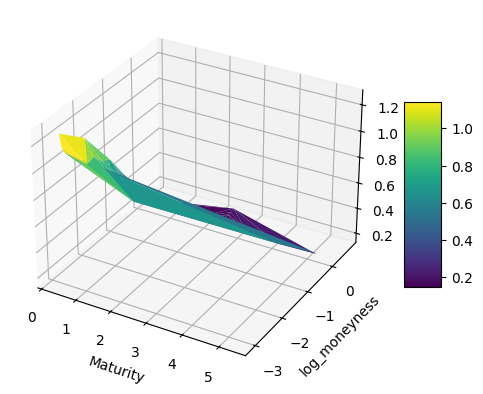

In [9]:
# Plot the volatilities
from option_pricing.vol_surface import VolSurface

builder = VolSurface(surface_data)
builder.plot_surface(surface_data)

In [10]:
# Maturity grid
max_expiry = pd.to_datetime(expiration_dates.max())
maturities = pd.date_range(start=pd.to_datetime(date) + pd.Timedelta(days=7), end=max_expiry, freq='1M')
maturity_grid = maturities.map(lambda x: (x - pd.to_datetime(date)) / pd.Timedelta(days=365))
maturity_grid = pd.Series(sorted(maturity_grid.unique()))

import numpy as np
log_moneyness_max = np.abs(combined['log_moneyness']).quantile(0.99)
log_moneyness_grid = np.linspace(-log_moneyness_max, log_moneyness_max, 100)
log_moneyness_grid = pd.Series(sorted(log_moneyness_grid))


/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_21332/773112699.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  maturities = pd.date_range(start=pd.to_datetime(date) + pd.Timedelta(days=7), end=max_expiry, freq='1M')


In [11]:
builder.build_svi_surface(maturity_grid, log_moneyness_grid, apply_penalty=True, penalty_lambda_=10)


Nan params:  a        2
b        2
rho      2
m        2
sigma    2
dtype: int64 Total params:  22
params                  a         b       rho         m     sigma
0.260274 -0.012066  0.080588 -0.045502  0.155584  0.220096
0.293151 -0.011045  0.087205 -0.046084  0.155816  0.219889
0.336986 -0.022108  0.126505 -0.050842  0.153902  0.218895
0.375342 -0.021393  0.125390 -0.050654  0.153705  0.219218
0.432877 -0.031751  0.167454 -0.057276  0.151052  0.218661
0.463014 -0.031252  0.166540 -0.057086  0.150904  0.218958
0.509589 -0.035922  0.188040 -0.060755  0.148884  0.219270
0.586301 -0.038834  0.203782 -0.063349  0.145636  0.221508
0.624658 -0.038539  0.203559 -0.063278  0.145548  0.221660
0.682192 -0.035041  0.196176 -0.061479  0.144184  0.223808
0.758904 -0.030843  0.197220 -0.061578  0.144691  0.224497
0.835616 -0.023321  0.198022 -0.061751  0.146188  0.226047
0.873973 -0.019474  0.199265 -0.061911  0.146739  0.226618
0.931507 -0.019185  0.199377 -0.061947  0.146870  0.226654
1.008219 

/Users/macaulay/Developer/Option_Pricing/option_pricing/vol_surface.py:175: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  params.ffill(inplace=True)


In [12]:
# plot the fitted surface
surface = builder.vol_surface


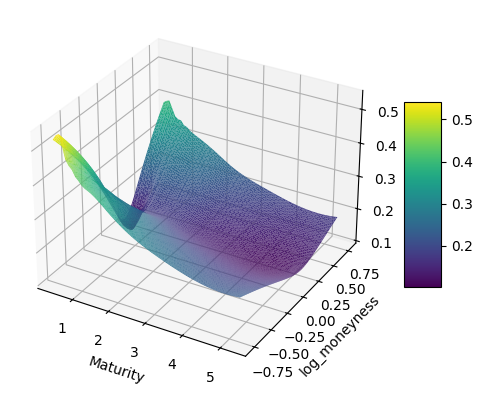

In [13]:
builder.plot_surface(surface[surface['maturity'] > 0.3])

In [14]:
# SSVI 

Builder3 = VolSurface(surface_data)

Builder3.build_ssvi_surface(maturity_grid, log_moneyness_grid)

SSVI parameters: rho = 0.2073420019838728, eta = 4.941732424231765, gamma = 0.3096066975688607
[0.0067474  0.00820621 0.00971365 0.01117247 0.0161268  0.01907208
 0.02322496 0.02752614 0.03133998 0.03528095 0.04089072 0.04519551
 0.04950029 0.05366621 0.05797099 0.06213691 0.0664417  0.07074648
 0.07477354 0.07907832 0.08324424 0.08754902 0.09171494 0.09601973
 0.10032451 0.10449043 0.10879521 0.11296113 0.11726591 0.1215707
 0.12545889 0.12976367 0.13392959 0.13823438 0.1424003  0.14670508
 0.15100986 0.15517578 0.15948057 0.16364649 0.16795127 0.17225605
 0.17614424 0.18044903 0.18461495 0.18891973 0.19308565 0.19739043
 0.20169522 0.20586114 0.21016592 0.21433184 0.21863662 0.22294141
 0.2268296  0.23113438 0.2353003  0.23960508 0.243771   0.24807579
 0.25238057 0.25654649 0.26085127 0.26501719]


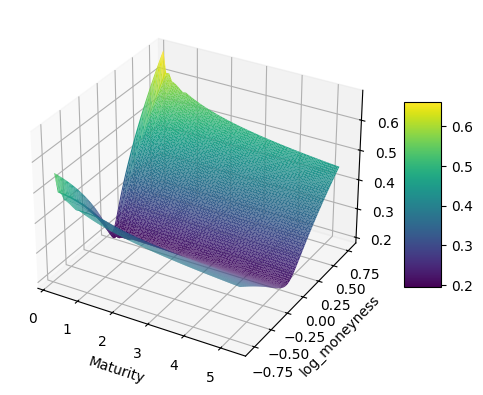

In [15]:
# Plot the fitted surface

surface3 = Builder3.vol_surface
Builder3.plot_surface(surface3[surface3['maturity'] > 0.2])


In [16]:
# local vol
from option_pricing.local_vol import local_volatilities

vol_matrix = pd.pivot_table(surface3[['maturity', 'log_moneyness', 'implied_vol']], index='maturity', columns='log_moneyness', values='implied_vol')
print(vol_matrix.head())



log_moneyness  -0.770314  -0.754752  -0.739191  -0.723629  -0.708067  \
maturity                                                               
0.043836        1.074519   1.064230   1.053840   1.043348   1.032751   
0.126027        0.679212   0.672733   0.666191   0.659584   0.652912   
0.210959        0.557340   0.552041   0.546692   0.541290   0.535835   
0.293151        0.496887   0.492178   0.487424   0.482623   0.477775   
0.378082        0.498612   0.493927   0.489198   0.484424   0.479603   

log_moneyness  -0.692505  -0.676943  -0.661381  -0.645819  -0.630257  ...  \
maturity                                                              ...   
0.043836        1.022045   1.011226   1.000292   0.989239   0.978062  ...   
0.126027        0.646172   0.639361   0.632478   0.625520   0.618485  ...   
0.210959        0.530324   0.524757   0.519130   0.513443   0.507692  ...   
0.293151        0.472878   0.467930   0.462930   0.457877   0.452768  ...   
0.378082        0.474733   0.4698

In [ ]:

local_vols = local_volatilities(vol_matrix.columns.values, vol_matrix.index.values, vol_matrix.values)

[-0.77031438 -0.75475247 -0.73919056 -0.72362866 -0.70806675 -0.69250484
 -0.67694294 -0.66138103 -0.64581912 -0.63025722 -0.61469531 -0.5991334
 -0.5835715  -0.56800959 -0.55244768 -0.53688578 -0.52132387 -0.50576196
 -0.49020006 -0.47463815 -0.45907624 -0.44351434 -0.42795243 -0.41239052
 -0.39682862 -0.38126671 -0.3657048  -0.3501429  -0.33458099 -0.31901908
 -0.30345718 -0.28789527 -0.27233337 -0.25677146 -0.24120955 -0.22564765
 -0.21008574 -0.19452383 -0.17896193 -0.16340002 -0.14783811 -0.13227621
 -0.1167143  -0.10115239 -0.08559049 -0.07002858 -0.05446667 -0.03890477
 -0.02334286 -0.00778095  0.00778095  0.02334286  0.03890477  0.05446667
  0.07002858  0.08559049  0.10115239  0.1167143   0.13227621  0.14783811
  0.16340002  0.17896193  0.19452383  0.21008574  0.22564765  0.24120955
  0.25677146  0.27233337  0.28789527  0.30345718  0.31901908  0.33458099
  0.3501429   0.3657048   0.38126671  0.39682862  0.41239052  0.42795243
  0.44351434  0.45907624  0.47463815  0.49020006  0.

In [19]:
# Heston Calibration
from option_pricing.Heston import calibrate_heston_from_surface

params, sse = calibrate_heston_from_surface(vol_matrix.columns.values,
                                            vol_matrix.index.values,
                                            vol_matrix.values)

kappa, theta, sigma, rho, v0 = params
print("Calibrated Heston parameters:")
print(f"kappa: {kappa}, theta: {theta}, sigma: {sigma}, rho: {rho}, v0: {v0}")
print("Sum of Squared Errors:", sse)

Calibrated Heston parameters:
kappa: 0.4158739495388935, theta: 0.5711440757186621, sigma: 0.28857225169362394, rho: 0.9952451792049027, v0: 9.572929388606345e-08
Sum of Squared Errors:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 292.7005586747044
        x: [-6.622e-01 -2.610e-01 -1.095e+00 -1.616e+01  3.020e+00]
      nit: 39
      jac: [-2.046e-04 -2.274e-05 -5.116e-05 -5.684e-06 -1.990e-04]
     nfev: 294
     njev: 49
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [20]:
# Pricing 
from option_pricing.MonteCarlo import MonteCarlowithHeston
from option_pricing.MonteCarloPricing import price_european

kappa, theta, sigma, rho, v0 = params
n_paths = 10000
n_steps = 10000
r = 0.03
T = max(surface_data['maturity'])
simulated_prices = MonteCarlowithHeston(S0=forward_prices['forward_price'].iloc[0],
                                        r=r,
                                        kappa=kappa,
                                        theta=theta,
                                        sigma=sigma,
                                        rho=rho,
                                        v0=v0,
                                        T=T,
                                        n_steps=n_steps,
                                        n_paths=n_paths)

dt = T / n_steps


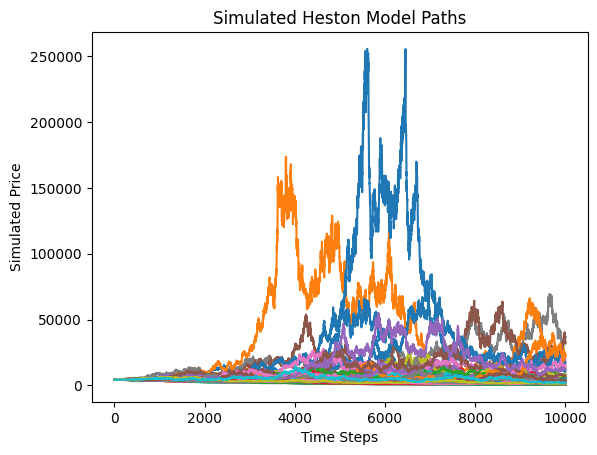

In [21]:
from matplotlib import pyplot as plt
idx = np.random.randint(0, n_paths, size=100)
plt.plot(simulated_prices[idx, :].T)  # Plot the first 100 simulated paths
plt.title('Simulated Heston Model Paths')
plt.xlabel('Time Steps')
plt.ylabel('Simulated Price')
plt.show()

In [23]:
surface_data['mc_price'] = np.nan

for i, row in surface_data.iterrows():

    col = row['maturity'] // dt 
    model_price = price_european(simulated_prices[:, int(col)],
                                 K=row['strike'],
                                 r=r,
                                 T=row['maturity'],
                                 option_type=row['option_type'])
    surface_data.at[i, 'mc_price'] = model_price

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.